In [1]:
# load necessary libraries
import numpy as np
from scipy import ndimage
from scipy import misc
from scipy import stats
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage import filters
from skimage.feature import canny
# for finding continuous sequences in a list
from operator import itemgetter
from itertools import groupby

# change plot size
mpl.rcParams['figure.figsize'] = (15, 15)

## Image modifying functions

In [2]:
# read in an image
def readImg(filename, plotIt = False):
    # read in image file
    let = misc.imread(filename)
    # read it in as grey
    grey = misc.imread(filename, flatten=True)
    
    if plotIt:        
        plt.imshow(let)
        plt.show()
        plt.imshow(grey, cmap = "gray")
        plt.show()
    return let, grey

# project the image onto a specific direction
def project(img, direction):
    if direction == "x":
        proj = np.sum(img, 0)
    elif direction == "y":
        proj = np.sum(img, 1)
    else:
        print("Direction must be one of 'x' or 'y'")
        proj = []
    return proj

def removeEdges(imgCol, imgGr, rmThresh = 0):
    imgGrCp = imgGr.copy()
    imgColCp = imgCol.copy()
    
    imgY = project(imgGrCp, "y")
    imgGrCp = imgGrCp[imgY > rmThresh]
    imgColCp = imgColCp[imgY > rmThresh]
    
    imgX = project(imgGrCp, "x")
    imgGrCp = imgGrCp[:,imgX > rmThresh]
    imgColCp = imgColCp[:,imgX > rmThresh]
    return imgColCp, imgGrCp

# binarize an image
def binarizeImg(img, biThresh, plotIt = False):
    imgCp = img.copy()
    if biThresh == "otsu":
        biThresh = filters.threshold_otsu(imgCp)
    inds = imgCp > biThresh
    imgCp[inds] = 1
    imgCp[np.logical_not(inds)] = 0
    if plotIt:
        plt.imshow(imgCp, cmap = "gray")
        plt.show()
    return imgCp

# smooth an image
def smoothImg(img, smoothSigma, plotIt = False):
    imgCp = ndimage.filters.gaussian_filter(input=img, sigma=smoothSigma)
    if plotIt:
        plt.imshow(imgCp, cmap = "gray")
        plt.show()
    return imgCp

# read in and do all pre-processing
def readAndPrep(filename, rmThresh = 0, biThresh = "otsu",
                smoothSigma = 10.0, plotIt = False):
    let, grey = readImg(filename, plotIt)
    let, grey = removeEdges(let, grey, rmThresh)
    greyBi = binarizeImg(grey, biThresh, plotIt)
    greySm = smoothImg(grey, smoothSigma, plotIt)
    return let, grey, greyBi, greySm

## Plotting functions

In [3]:
# plot "histogram"
def densityHist(proj, pers = []):
    plt.plot(proj)
    ny = proj.shape[0]
    for pe in pers:
        p = np.percentile(proj, pe)
        plt.plot([0,ny], [p, p])
        plt.text(x=ny, y=p, s=str(pe))
    plt.show()

# plot boxes around words (or just linebreaks)
def plotBoxes(img, linebreaks, wordbreaks = []):
    if len(linebreaks) == 0:
        linebreaks = [0, img.shape[0]]
    plt.imshow(img)
    for i in range(len(linebreaks)):
        plt.plot([0,img.shape[1]], [linebreaks[i], linebreaks[i]], 'b')
    for i in range(len(linebreaks)-1):
        plt.plot([wordbreaks[i], wordbreaks[i]], [linebreaks[i], linebreaks[i+1]], 'b')
    plt.show()

## Segmentation functions

In [4]:
# get breaks based on projection
def projBreaks(img, direction, thresh = 0):
    proj = project(img, direction)
    breaks = argrelextrema(proj, np.greater_equal)[0]
    breaks = breaks[breaks > thresh-1]
    # append 0 and image size to ends of vector
    if not breaks[0] == 0:
        breaks = np.insert(breaks, 0, 0)
    if not breaks[-1] == proj.shape[0]:
        breaks = np.append(breaks, proj.shape[0]) 
    return breaks.astype("int")

# get the breaks based on canny edge detection
def edgeBreaks(img, direction, thresh = 0):
    edges = canny(img, 5, 1, 25)
    eproj = project(edges, direction)
    br = np.sort(np.where(eproj <= thresh)[0])
    # get middle (mean) of continuous sequences
    breaks = []
    for k, g in groupby(enumerate(br), lambda ix:ix[0]-ix[1]):
        group = list(map(itemgetter(1), g))
        breaks.append(np.mean(group))
    # append 0 and image size to ends of vector
    if not breaks[0] == 0:
        breaks = np.insert(breaks, 0, 0)
    if not breaks[-1] == eproj.shape[0]:
        breaks = np.append(breaks, eproj.shape[0]) 
    return breaks.astype("int")
    
# split into words
def getWordBreaks(img, lineBreaks, method = "edge", thresh = 0):
    wordbreaks = []
    for i in range(len(lineBreaks)-1):
        chunk = img[lineBreaks[i]:lineBreaks[i+1],]
        if method == "edge":
            wordbreaks.append(edgeBreaks(chunk, "x", thresh))
        elif method == "proj":
            wordbreaks.append(projBreaks(chunk, "x", thresh))
    return wordbreaks

# segment the whole document
def segmentDoc(origImg, grImg1, grImg2, m1 = "proj", m2 = "edge",
               th1 = 0, th2 = 0, plotIt = True):
    # get line breaks
    if m1 == "proj":
        lineBreaks = projBreaks(grImg1, "y", th1)
    elif m1 == "edge":
        lineBreaks = edgeBreaks(grImg1, "x", th1)
    # get word breaks
    wordBreaks = getWordBreaks(grImg2, lineBreaks, m2, th2)
    # plot the image
    if plotIt:
        plotBoxes(origImg, lineBreaks, wordBreaks)
    return lineBreaks, wordBreaks

## Save images

In [5]:
# save all segments to a folder
def saveSegments(img, lb, wb, fname, folder = "./", ftype = ".png"):
    prefix = folder + fname
    for i in range(len(lb)-1):
        for j in range(len(wb[i])-1):
            colrow = str(int(lb[i])) + "_" + str(int(wb[i][j]))
            nm = prefix + "_" + colrow + ftype
            chunk = img[lb[i]:lb[i+1], wb[i][j]:wb[i][j+1]]
            misc.imsave(nm, chunk)

## Run segmentation on a couple of images

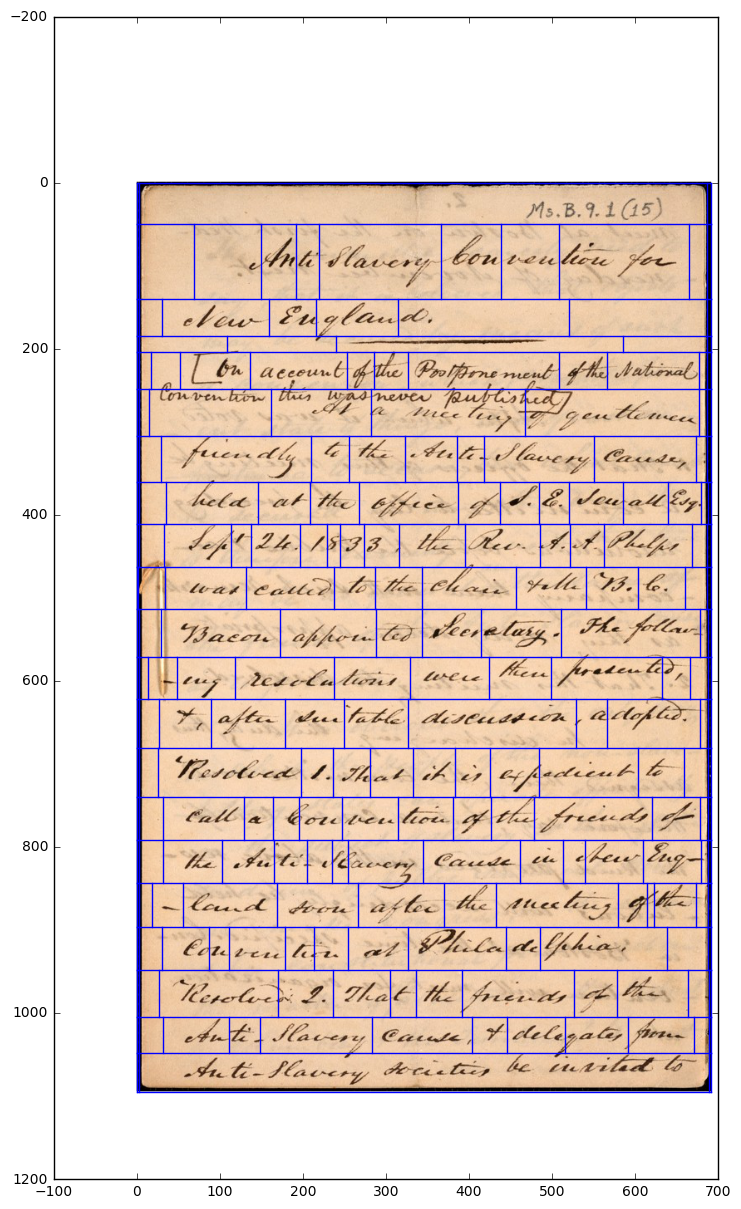

In [6]:
let, grey, greyBi, greySm = readAndPrep("images/easy1.jpg")
lb, wb = segmentDoc(let, greySm, grey)
saveSegments(let, lb, wb, "easy1", "segmented_img/")

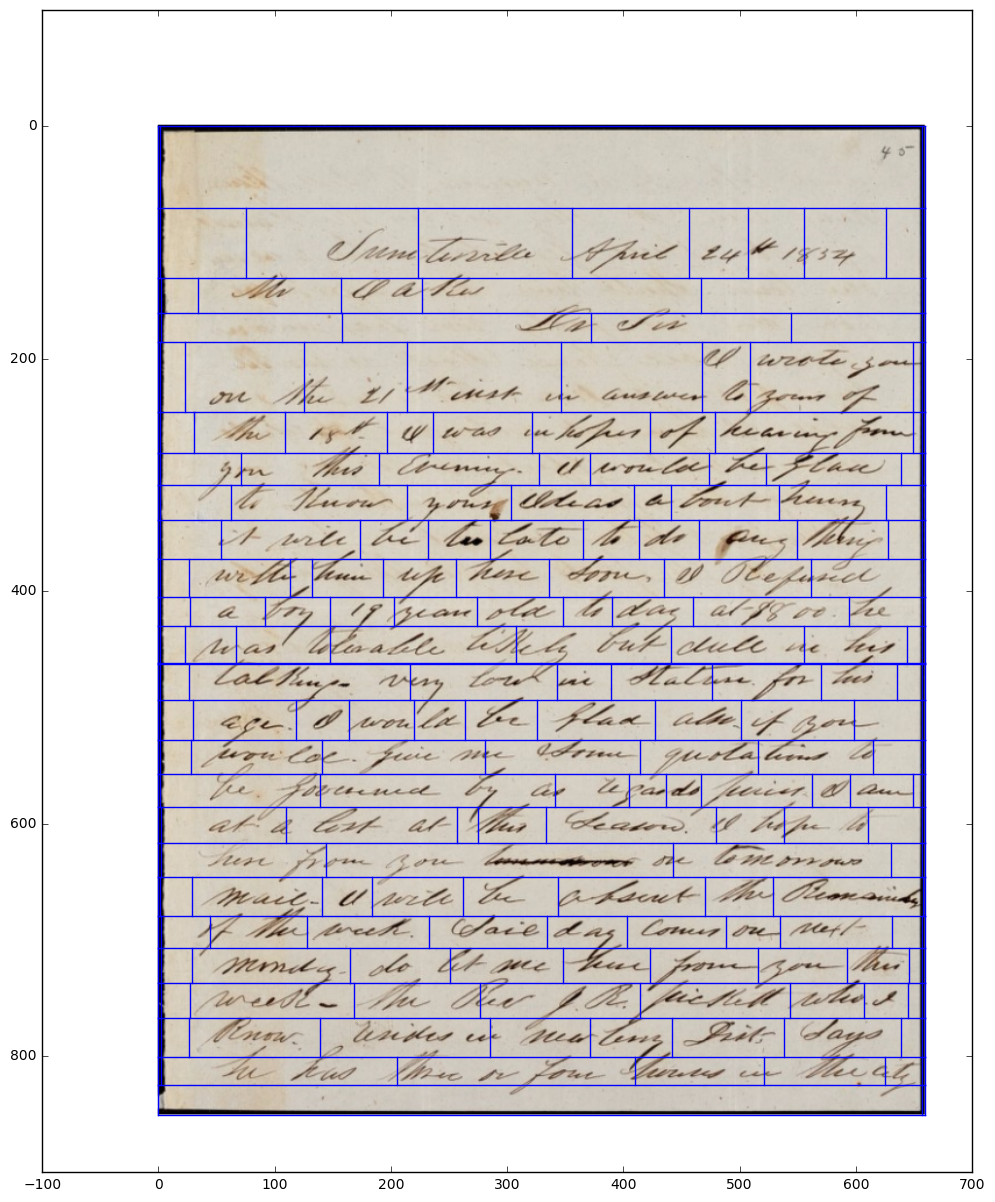

In [7]:
let, grey, greyBi, greySm = readAndPrep("images/medium1.png")
lb, wb = segmentDoc(let, greySm, grey)
saveSegments(let, lb, wb, "medium1", "segmented_img/")

# Old code

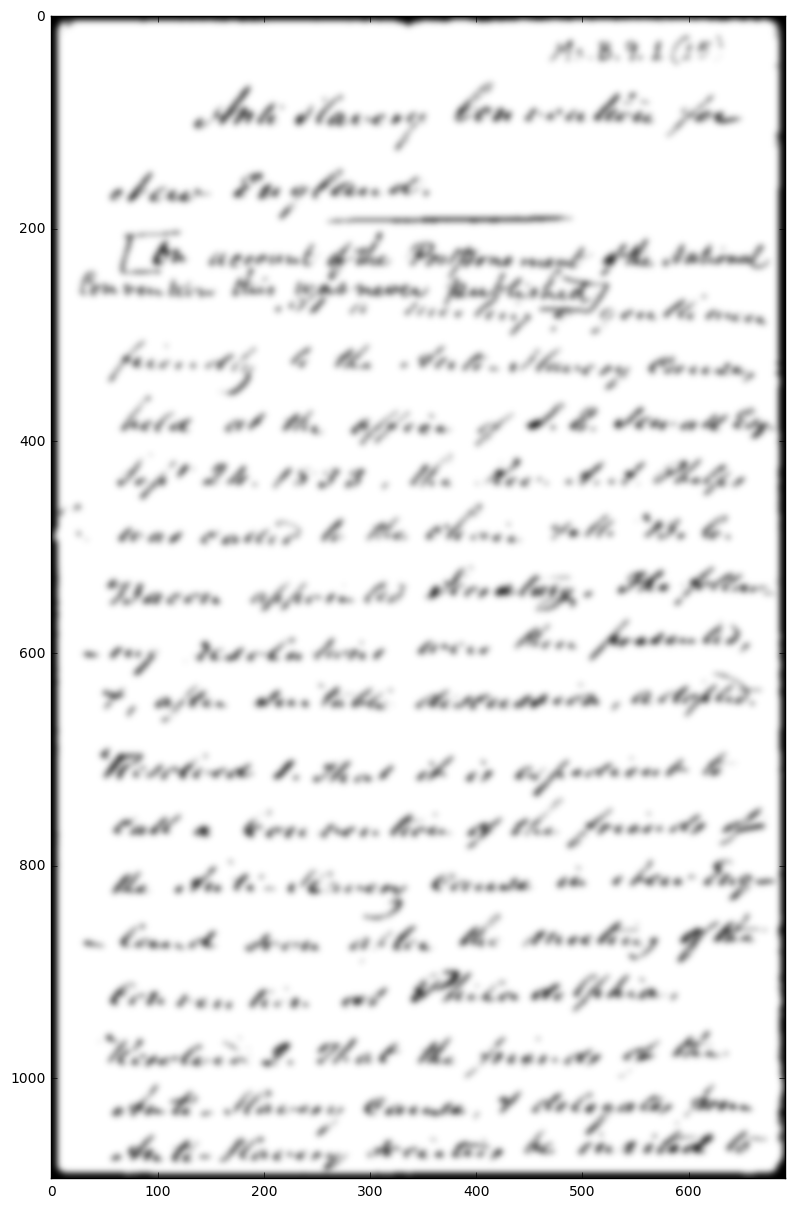

In [8]:
let, grey = readImg("images/easy1.jpg")
let, grey = removeEdges(let, grey)
grBi = binarizeImg(grey, "otsu")
grSm = smoothImg(grBi, 3)
plt.imshow(grSm, cmap="gray")
plt.show()